In [3]:
# Import python packages that are used here
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob
import cmath as cm
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from glob import glob
from matplotlib.pyplot import figure
import os
import sys


# Import `functions.py` to help us to import measured data
from functions import import_pol_data
from functions import import_lin_data
from functions import import_TD_data
from functions import Do_the_thing

In [4]:
# Change the path here to the folder that contains the data
root_path = r'/Users/itungchen/UW_lab_data/'
DL_dir_name =  root_path + '/20230426-SOS-acoustic-rings//'

# Define the sort function of the frequency domain data
def sortKeyFunc_FD(s):
    return int(os.path.basename(s)[4:5])

file_name = ['35K-*-S11-1um-wg-pol.prn', '35K-*-S12-1um-wg-pol.prn', '35K-*-S21-1um-wg-pol.prn', '35K-*-S22-1um-wg-pol.prn']

# Grab file name and store in DL list
DL_4K_S11 = glob(DL_dir_name + file_name[0])
DL_4K_S11.sort(key = sortKeyFunc_FD)
DL_4K_S22 = glob(DL_dir_name + file_name[3])
DL_4K_S22.sort(key = sortKeyFunc_FD)
DL_4K_S12 = glob(DL_dir_name + file_name[1])
DL_4K_S12.sort(key = sortKeyFunc_FD)
DL_4K_S21 = glob(DL_dir_name + file_name[2])
DL_4K_S21.sort(key = sortKeyFunc_FD)

# Import frequency domain data
S11_list_4K = []
S22_list_4K = []
S12_list_4K = []
S21_list_4K = []

for fn_11, fn_12, fn_21, fn_22 in zip(DL_4K_S11, DL_4K_S12, DL_4K_S21, DL_4K_S22):
    freq11, r11, i11 = import_pol_data(fn_11)
    freq12, r12, i12 = import_pol_data(fn_12)
    freq21, r21, i21 = import_pol_data(fn_21)
    freq22, r22, i22 = import_pol_data(fn_22)
    
    S11_list_4K.append(r11 + 1j*i11)
    S12_list_4K.append(r12 + 1j*i12)
    S21_list_4K.append(r21 + 1j*i21)
    S22_list_4K.append(r22 + 1j*i22)
    

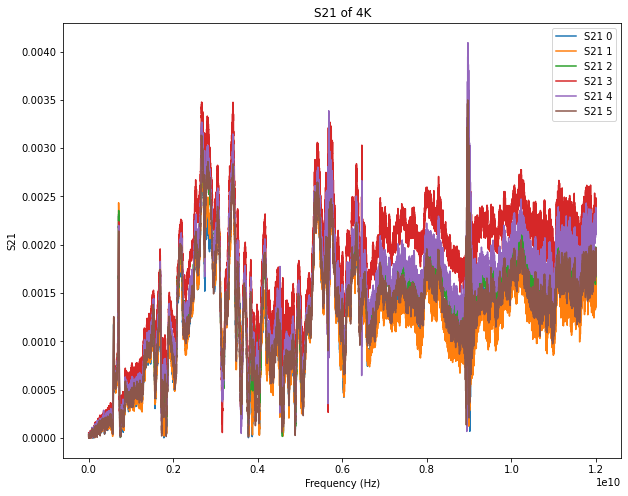

In [5]:
# Plot all the S21 data in 4K in one plot
fig, ax = plt.subplots(1,1, figsize=(10, 8))
for i in range(len(S21_list_4K)):
    ax.plot(freq21, np.abs(S21_list_4K[i]), label = 'S21 ' + str(i))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('S21')
ax.set_title('S21 of 4K')
ax.legend()


# Fourier transform
The S21 data and plot the time domain data.

        L_delay = [30, 45, 70, 100, 140, 650, 950, 1400, 2000, 3020, 4300, 4600] # in um
        T_list = [4, 7, 13.9, 30, 40, 60, 95, 140, 210, 300]




In [6]:
import scipy.fft

def ifft_complex_data(cmpl_s21, freq, print_time_reso = True):
    # import the data
    N_pts = len(cmpl_s21)

    # Perform ifft on the imported data
    s21_ift = scipy.fft.ifft(cmpl_s21)

    # Calculate the time resolution
    t_reso = 1/((freq[-1]-freq[0]))
    
    if print_time_reso:
        print('Time resolution is:', t_reso, 'nano sec')

    # The time here inclued the flipped data
    t_span = np.array(range(N_pts))*t_reso #s

    return N_pts, s21_ift, t_span, t_reso

In [7]:
ifft_list_4K = []
for cmpl_s21 in S21_list_4K:
    N_pts, s21_ift, t_span, t_reso = ifft_complex_data(cmpl_s21, freq21, print_time_reso = False)
    ifft_list_4K.append(s21_ift)


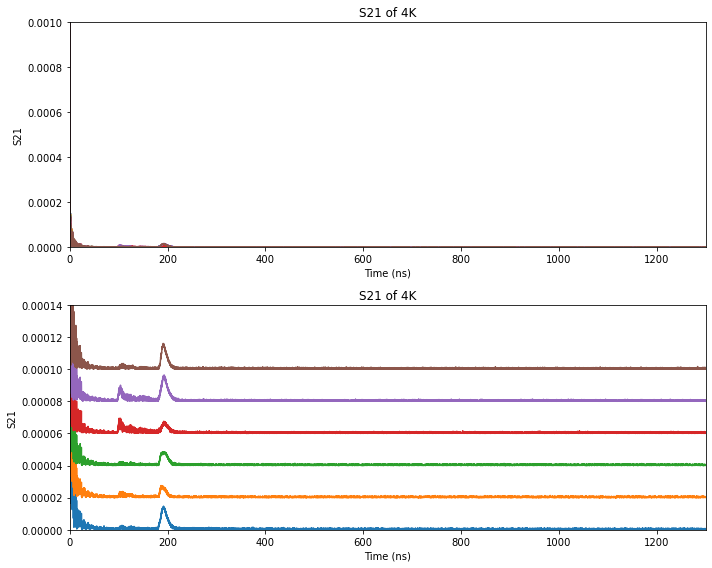

In [8]:
# Plot two plots: one is the time domain with a larger time span, the other is the time domain with a smaller time span and smaller y limit
fig, ax = plt.subplots(2,1, figsize=(10, 8))
for i in range(len(ifft_list_4K)):
    ax[0].plot(t_span/1e-9, np.abs(ifft_list_4K[i]), label = 'S21 ' + str(i))
    ax[1].plot(t_span/1e-9, np.abs(ifft_list_4K[i]) + 2e-5*i, label = 'S21 ' + str(i))

ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('S21')
ax[0].set_title('S21 of 4K')
ax[0].set_xlim(0, 1300)
ax[0].set_ylim(0, 0.001)
#ax[0].legend()

ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('S21')
ax[1].set_title('S21 of 4K')
#ax[1].legend()
ax[1].set_xlim(0, 1300)
ax[1].set_ylim(0, 0.00014)

plt.tight_layout()

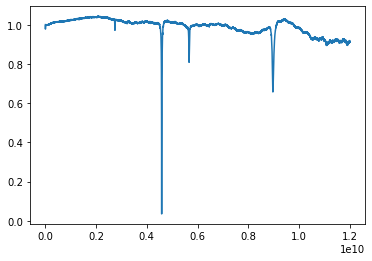

In [9]:
plt.plot(freq21, np.abs(S11_list_4K[1]), label = 'S21 ' + str(i))


# Time Gating
This is the list that stores the ifft data, and the time span of the data.

        ifft_list_4K, t_span

Now we will try to time gate the data and trasform back to look at the S21 in frequenct domain using the function 

        Filter_S21_singnals

In [10]:
from S21Gating import Filter_S21_signals

time_gated_FD_list_4K = []
for ifft_data in ifft_list_4K:
    _, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq21, 
                                                                                    ifft_data, 
                                                                                    t_reso,   
                                                                                    N_pts = N_pts,  
                                                                                    filter_noise = True,
                                                                                    filter_peaks = False,
                                                                                    filter_picking = False, 
                                                                                    filter_stop = True,
                                                                                    t_noise=[150], expand_noise = 0.1,
                                                                                    t_peaks=[0], expand_peaks = 200,
                                                                                    t_picked = [0], expand_picked = 20,
                                                                                    t_stop = 500,
                                                                                    xmax=1000, ymax=1000e-8, ymax_fdom = 3e-5, manual_scale= False,
                                                                                    savefig = False,
                                                                                    plot_filtering = False)

    time_gated_FD_list_4K.append(nor_cmpl_filtered)

Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...
Filtering(1) noise...


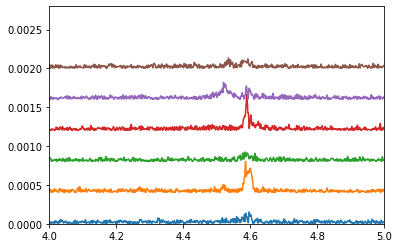

In [11]:
for i, time_gated_data in enumerate(time_gated_FD_list_4K):
    plt.plot(freq21/1e9, np.abs(time_gated_data)+ i*4e-4)

plt.xlim(4, 5)
plt.ylim(0,2.8e-3)

# Set plt size 
plt.rcParams['figure.figsize'] = [10, 8]

In [12]:
def import_ring_data(root_path, dir_name, file_name, sort_indx):
    # Change the path here to the folder that contains the data
    DL_dir_name =  root_path + dir_name

    # Define the sort function of the frequency domain data
    def sortKeyFunc_FD(s):
        return int(os.path.basename(s)[sort_indx[0]:sort_indx[1]])

    # Grab file name and store in DL list
    DL_4K_S11 = glob(DL_dir_name + file_name[0])
    DL_4K_S11.sort(key = sortKeyFunc_FD)
    DL_4K_S22 = glob(DL_dir_name + file_name[3])
    DL_4K_S22.sort(key = sortKeyFunc_FD)
    DL_4K_S12 = glob(DL_dir_name + file_name[1])
    DL_4K_S12.sort(key = sortKeyFunc_FD)
    DL_4K_S21 = glob(DL_dir_name + file_name[2])
    DL_4K_S21.sort(key = sortKeyFunc_FD)

    # Import frequency domain data
    S11_list_4K = []
    S22_list_4K = []
    S12_list_4K = []
    S21_list_4K = []

    for fn_11, fn_12, fn_21, fn_22 in zip(DL_4K_S11, DL_4K_S12, DL_4K_S21, DL_4K_S22):
        freq11, r11, i11 = import_pol_data(fn_11)
        freq12, r12, i12 = import_pol_data(fn_12)
        freq21, r21, i21 = import_pol_data(fn_21)
        freq22, r22, i22 = import_pol_data(fn_22)
        
        S11_list_4K.append(r11 + 1j*i11)
        S12_list_4K.append(r12 + 1j*i12)
        S21_list_4K.append(r21 + 1j*i21)
        S22_list_4K.append(r22 + 1j*i22)
    
    return freq11, S11_list_4K, S22_list_4K, S12_list_4K, S21_list_4K
        

In [42]:
root_path = r'/Users/itungchen/UW_lab_data/'
dir_name = '/20230515-sos-acoring-drycham//' 
file_name = ['30K-*-S11-1um-wg-pol.prn', '30K-*-S12-1um-wg-pol.prn', '30K-*-S21-1um-wg-pol.prn', '30K-*-S22-1um-wg-pol.prn']
sort_indx = [4,5]
freq, S11_list_4K, S22_list_4K, S12_list_4K, S21_list_4K = import_ring_data(root_path, dir_name, file_name, sort_indx)

In [43]:
ifft_list_4K = []
for cmpl_s21 in S21_list_4K:
    N_pts, s21_ift, t_span, t_reso = ifft_complex_data(cmpl_s21, freq, print_time_reso = True)
    ifft_list_4K.append(s21_ift)

Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec
Time resolution is: 1.4285714285714285e-10 nano sec


* S21 at 30K.  

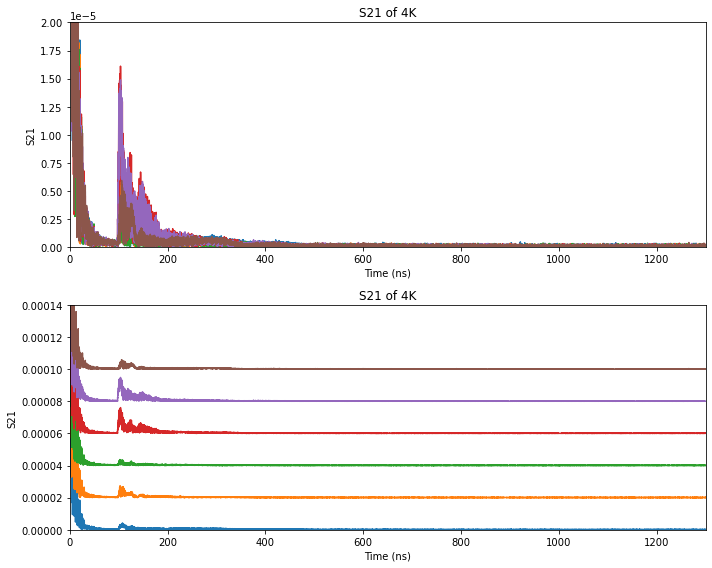

In [47]:
# Plot two plots: one is the time domain with a larger time span, the other is the time domain with a smaller time span and smaller y limit
fig, ax = plt.subplots(2,1, figsize=(10, 8))
for i in range(len(ifft_list_4K)):
    ax[0].plot(t_span/1e-9, np.abs(ifft_list_4K[i]), label = 'S21 ' + str(i))
    ax[1].plot(t_span/1e-9, np.abs(ifft_list_4K[i]) + 2e-5*i, label = 'S21 ' + str(i))

ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('S21')
ax[0].set_title('S21 of 4K')
ax[0].set_xlim(0, 1300)
ax[0].set_ylim(0, 2e-5)
#ax[0].legend()

ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('S21')
ax[1].set_title('S21 of 4K')
#ax[1].legend()
ax[1].set_xlim(0, 1300)
ax[1].set_ylim(0, 0.00014)

plt.tight_layout()

Acoustic velocity 650um/100ns = 6500 m/s 

Acoustic ring total length (race track ring, diameter 100um racetrack 25um) = 346um

In [112]:
v_Ac = 650e3/100
L_ring = np.pi*100 + 50
L_wg = 589
print('acoustic velocity = ', v_Ac, 'm/s' )
print('Ring length= ', np.pi*100 + 50, 'um')
print('through waveguide length= ', 589, 'um') 

print('arrivial time = ', L_wg/v_Ac*1e3, 'ns')
print('Ring time = ', L_ring/v_Ac*1e3, 'ns')

acoustic velocity =  6500.0 m/s
Ring length=  364.1592653589793 um
through waveguide length=  589 um
arrivial time =  90.61538461538461 ns
Ring time =  56.0245023629199 ns


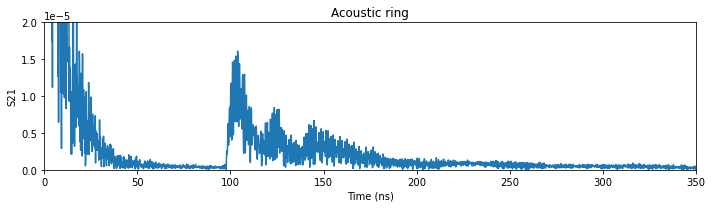

In [105]:
fig, ax = plt.subplots(1,1, figsize=(10, 3))

ax.plot(t_span/1e-9, np.abs(ifft_list_4K[3]), label = 'S21 ' + str(i))

ax.set_xlabel('Time (ns)')
ax.set_ylabel('S21')
ax.set_title('Acoustic ring')
ax.set_xlim(0, 350)
ax.set_ylim(0, 2e-5)
#ax[0].legend()

plt.tight_layout()

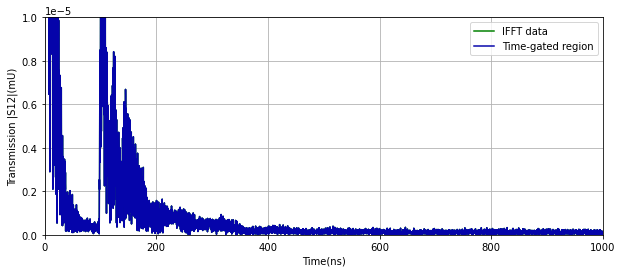

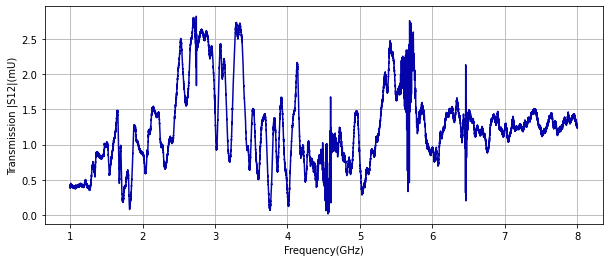

In [148]:
_, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq, 
                                                                                ifft_list_4K[3], 
                                                                                t_reso,   
                                                                                N_pts = N_pts,  
                                                                                filter_noise = False,
                                                                                filter_peaks = False,
                                                                                filter_picking = False, 
                                                                                filter_stop = False,
                                                                                t_noise=[60], expand_noise = 0.1,
                                                                                t_peaks=[110], expand_peaks = 25,
                                                                                t_picked = [0], expand_picked = 20,
                                                                                t_stop = 500,
                                                                                xmax=1000, ymax=1000e-8, ymax_fdom = 3e-5, manual_scale= False,
                                                                                savefig = False,
                                                                                plot_filtering = True)

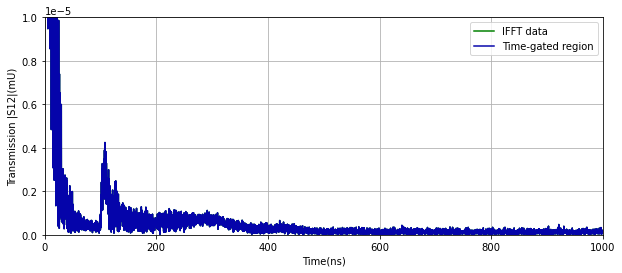

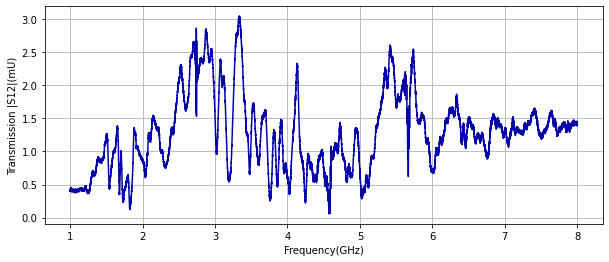

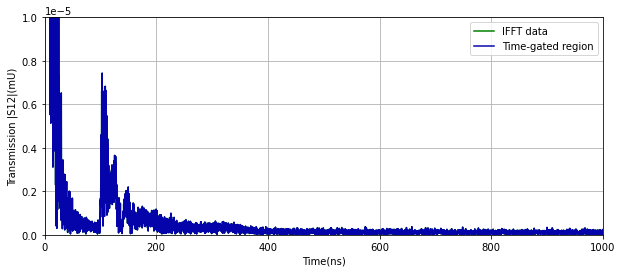

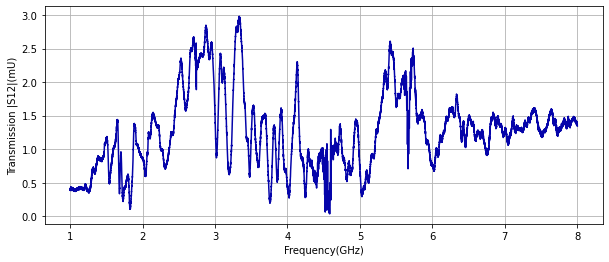

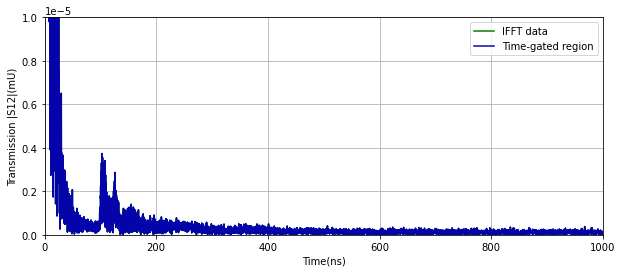

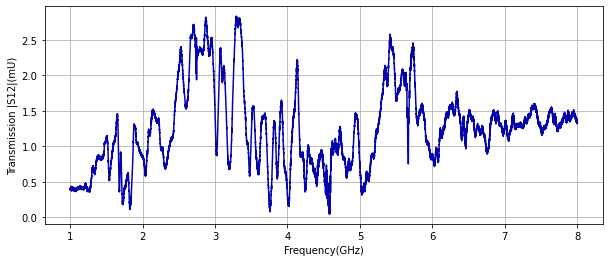

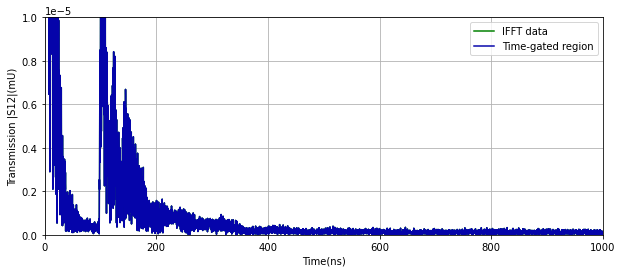

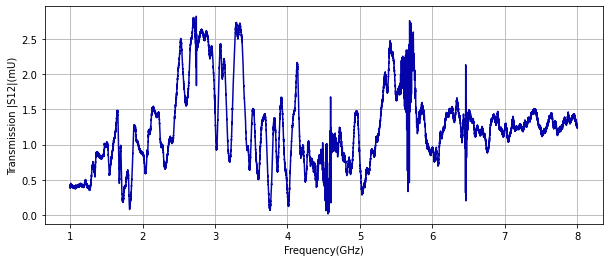

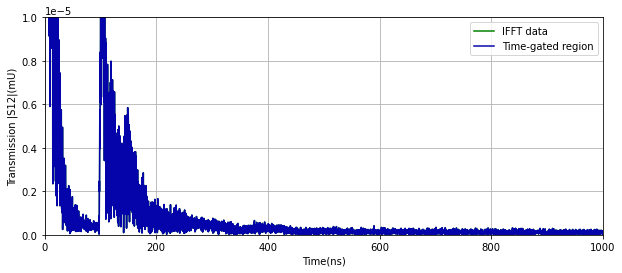

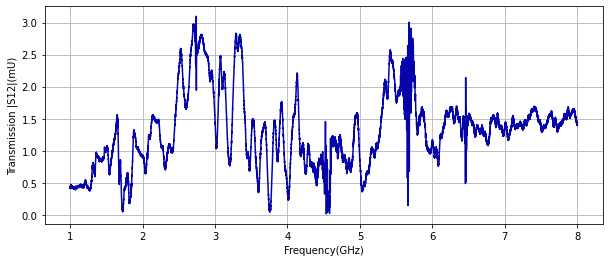

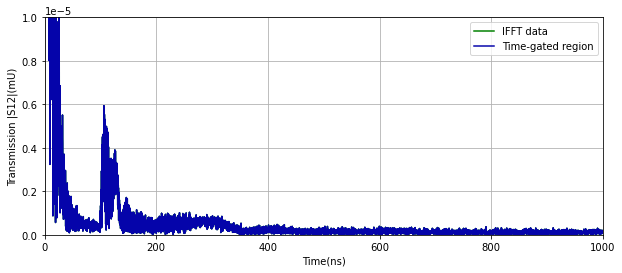

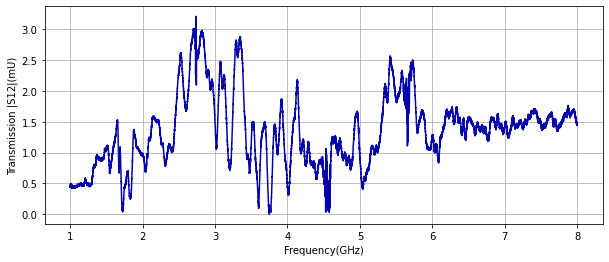

In [149]:
time_gated_FD_list_4K = []
for ifft_data in ifft_list_4K:
    _, nor_cmpl_filtered, t_span, ift_data, org_ift_data = Filter_S21_signals(   freq, 
                                                                                    ifft_data, 
                                                                                    t_reso,   
                                                                                    N_pts = N_pts,  
                                                                                    filter_noise = False,
                                                                                    filter_peaks = False,
                                                                                    filter_picking = False, 
                                                                                    filter_stop = False,
                                                                                    t_noise=[60], expand_noise = 0.1,
                                                                                    t_peaks=[150], expand_peaks = 10,
                                                                                    t_picked = [0], expand_picked = 20,
                                                                                    t_stop = 500,
                                                                                    xmax=1000, ymax=1000e-8, ymax_fdom = 3e-5, manual_scale= False,
                                                                                    savefig = False,
                                                                                    plot_filtering = True)

    time_gated_FD_list_4K.append(nor_cmpl_filtered)

Haoquin- LOOK HERE -This is the resonance raw signal (without filtering) of the ring. Please compare this with the filtered ring resonance signal.

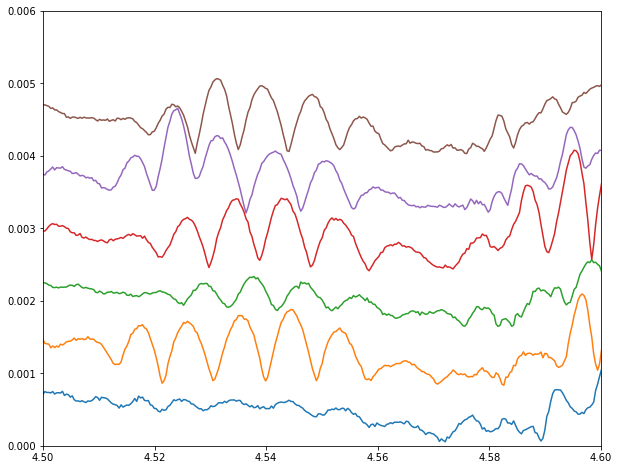

In [166]:
for i, time_gated_data in enumerate(time_gated_FD_list_4K):
    plt.plot(freq/1e9, np.abs(time_gated_data)+ i*8e-4)

plt.xlim(4.5, 4.6)
plt.ylim(0,6e-3)

# Set plt size 
plt.rcParams['figure.figsize'] = [10, 8]

In [172]:
4.54/0.004

1135.0

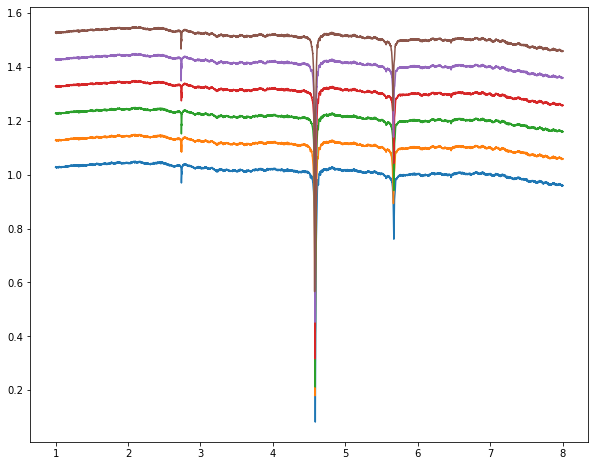

In [164]:
for i, s11 in enumerate(S11_list_4K):
    plt.plot(freq/1e9, np.abs(s11)+0.1*i)